# A Projected Langevin Algorithm for Constrained Localization

This code is a companion for the paper:

"Projected Stochastic Gradient Langevin Algorithms for Constrained Sampling and Non-Convex Learning"
https://arxiv.org/abs/2012.12137

It implements uses the projected Langevin algorithm from that paper to implement map-based localization with a proximity sensor. The main idea is to see how method correctly samples from the posterior while respecting the constraints.

# Problem Setup

The true position of a proximity sensor, $x$, is assumed to lie in a square region $[-W/2,W/2]\times [-W/2,W/2]$.

Beacons are placed at random locations in the square region, $b_i$ , for $i=1,\ldots,m$, where $m$ is the number of beacons. 

The sensor recieves a reading of the form $y_i = \|x^\star - b_i\|+v_i$ from each region. Here $\|\cdot \|$ is the Euclidean norm and $v_i$ is Gaussian noise with zero mean and standard deviation $\sigma$.

Assume that $x$ has a uniform prior over the region. The goal is to sample from the posterior
$$
p(x|y_1,\ldots,y_m).
$$

Importantly, the prior enforces that $x$ must stay in the square region at all times, since it puts zero mass outside of the square. 

# The Code

The code below implements the projected Langevin method to sample from the posterior for $x$ in two different locations of the region. 

In [1]:
import torch as pt
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.integrate as itg

%matplotlib inline

/home/andy/.local/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 5000/5000 [00:01<00:00, 2862.65it/s]
/home/andy/.local/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 5000/5000 [00:01<00:00, 3250.46it/s]


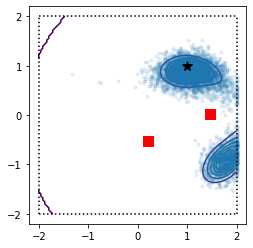

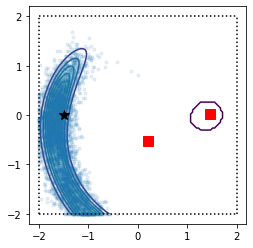

In [2]:
Width = 4
Unif = pt.distributions.Uniform(-Width/2,Width/2)
pt.manual_seed(389)

# 
beaconLocations = Unif.sample((2,2))


sensor_std = .2
noiseModel = pt.distributions.Normal(loc=0.,scale=sensor_std)

def dist_fun(x):
    NumBeacons = len(beaconLocations)
    d = pt.norm(beaconLocations - pt.outer(pt.ones(NumBeacons),x),dim=1)
    return d
    
def proximityMeasurement(x):
    d = dist_fun(x)
    return d + sensor_std * pt.randn_like(d)



def loss_fun(x,y):
    d = dist_fun(x)
    return -pt.sum(noiseModel.log_prob(y-d))




#x_true = pt.tensor([1.5,.8])




        

NumSteps = 5000
eta = .01

NumRuns = 2

X_true = pt.tensor([[1.,1.],
                   [-1.5,0.]])

for run in range(NumRuns):
    
    x_true = X_true[run]
    y = proximityMeasurement(x_true)
    
    
    def likelihood(x2,x1):

        x_pt = pt.tensor([x1,x2],dtype=y.dtype)
        loss = loss_fun(x_pt,y)
        p = pt.exp(-loss)
        return p.detach().numpy()
    
    normalizingConstant = itg.dblquad(likelihood,-Width/2,Width/2,-Width/2,Width/2)[0]
    
    def normalized_pdf(x):
        x_pt = pt.tensor(x,dtype=y.dtype)
        loss = loss_fun(x_pt,y)
        p = pt.exp(-loss)/normalizingConstant
        return p

    Xc,Yc = np.meshgrid(np.linspace(-Width/2,Width/2,100),np.linspace(-Width/2,Width/2,100))
    Zc = np.zeros_like(Xc)
    for i in range(Xc.shape[0]):
        for j in range(Xc.shape[1]):
            x_ij = Xc[i,j]
            y_ij = Yc[i,j]
            p = normalized_pdf(np.array([x_ij,y_ij]))
            Zc[i,j] = p

    x = Unif.sample((2,))
    x = x.detach().clone().requires_grad_(True)

    X = [x]

    for step in tqdm(range(NumSteps)):
        x.grad = pt.zeros_like(x)
    
        loss = loss_fun(x,y)
        loss.backward(retain_graph=True)
    
        g = x.grad
    
        x = x -eta * g + np.sqrt(2*eta) * pt.randn_like(x)
        x = pt.clamp(x,-Width/2,Width/2)
        x = x.detach().clone().requires_grad_(True)
    
        X.append(x)
    
    
    
    X = pt.stack(X)
    X_np = X.detach().numpy()
    
    plt.figure()
    

    plt.contour(Xc,Yc,Zc)

    plt.plot(X_np[:,0],X_np[:,1],'.',alpha=.1)
    plt.plot(x_true[0],x_true[1],marker='*',color='k',markersize=10)
    plt.plot(beaconLocations[:,0],beaconLocations[:,1],'s',color='r',markersize=10)

    plt.plot([-Width/2,-Width/2],[-Width/2,Width/2],'k:')
    plt.plot([Width/2,Width/2],[-Width/2,Width/2],'k:')
    plt.plot([-Width/2,Width/2],[Width/2,Width/2],'k:')
    plt.plot([-Width/2,Width/2],[-Width/2,-Width/2],'k:')
    plt.xlim([-2.2,2.2])
    plt.ylim([-2.2,2.2])
    plt.yticks([-2,-1,0,1,2])
    plt.gca().set_aspect('equal')
    plt.savefig('localization_run%d.pdf' % (run+1,),bbox_inches='tight',transparent=True)
    